In [1]:
# ===============================================
# Player Injuries Analysis & Prediction
#Author: Anirban
# ===============================================

Cloning into 'My_Projects'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 3), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 212.54 KiB | 5.90 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [19]:
# 1️⃣ Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")

In [21]:

# Load Dataset

df_injury = pd.read_csv('/content/drive/MyDrive/Football_data/player_injuries/player_injuries.csv')
print("Dataset shape:", df_injury.shape)
print(df_injury.head())

# Data Cleaning

# Convert dates
df_injury['from_date'] = pd.to_datetime(df_injury['from_date'], errors='coerce')
df_injury['end_date'] = pd.to_datetime(df_injury['end_date'], errors='coerce')

# Fill missing days_missed based on dates
df_injury['days_missed'] = df_injury['days_missed'].fillna((df_injury['end_date'] - df_injury['from_date']).dt.days)
df_injury['games_missed'] = df_injury['games_missed'].fillna(0)

# Drop rows with missing critical info
df_injury = df_injury.dropna(subset=['player_id', 'season_name', 'days_missed', 'games_missed'])

Dataset shape: (77871, 7)
   player_id season_name  injury_reason   from_date    end_date  days_missed  \
0     749087       22/23  Facial injury  2022-09-11  2022-09-21         11.0   
1     187288       23/24  Muscle injury  2023-12-10  2023-12-25         16.0   
2     187288       23/24  Muscle injury  2023-11-20  2023-12-05         16.0   
3     187288       23/24  Muscle injury  2023-08-10  2023-09-05         27.0   
4     187288       21/22    minor knock  2021-11-25  2021-11-28          4.0   

   games_missed  
0             2  
1             2  
2             2  
3             4  
4             1  


/tmp/ipython-input-3536049961.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=injuries_per_season, x='season_name', y='injury_count', palette='magma')


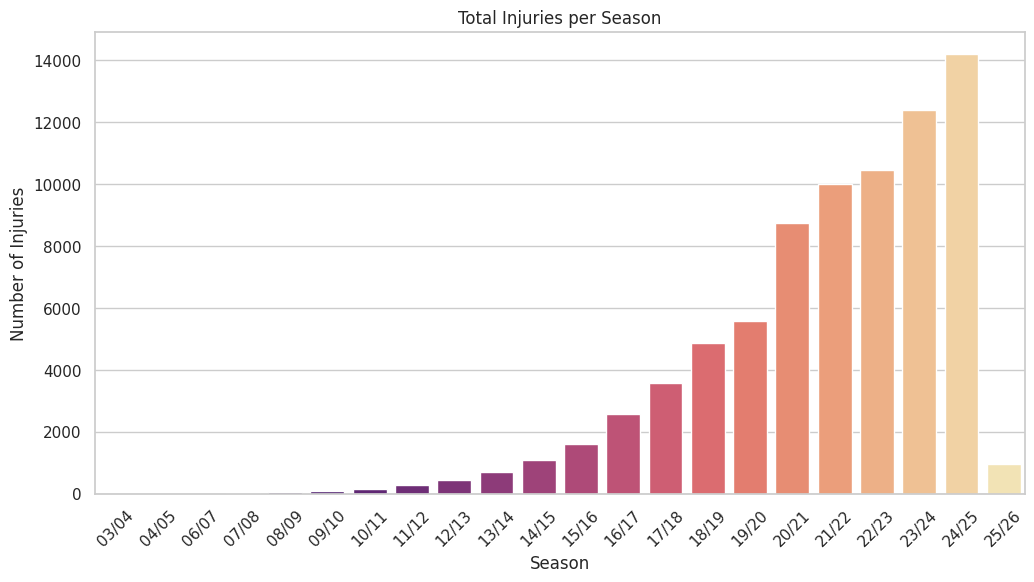

/tmp/ipython-input-3536049961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_injuries.values, y=top_injuries.index, palette='viridis')


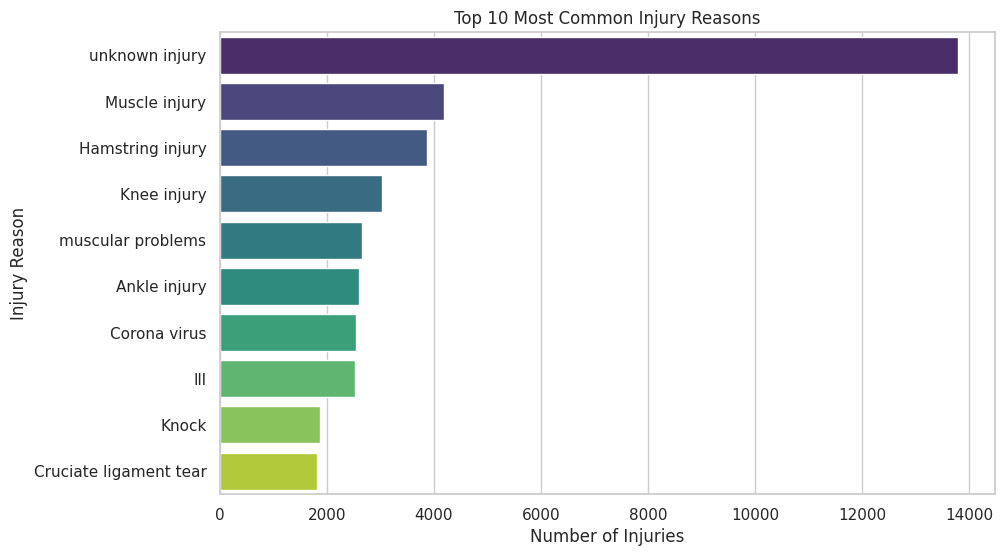

/tmp/ipython-input-3536049961.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_players.values, y=top_players.index, palette='rocket')


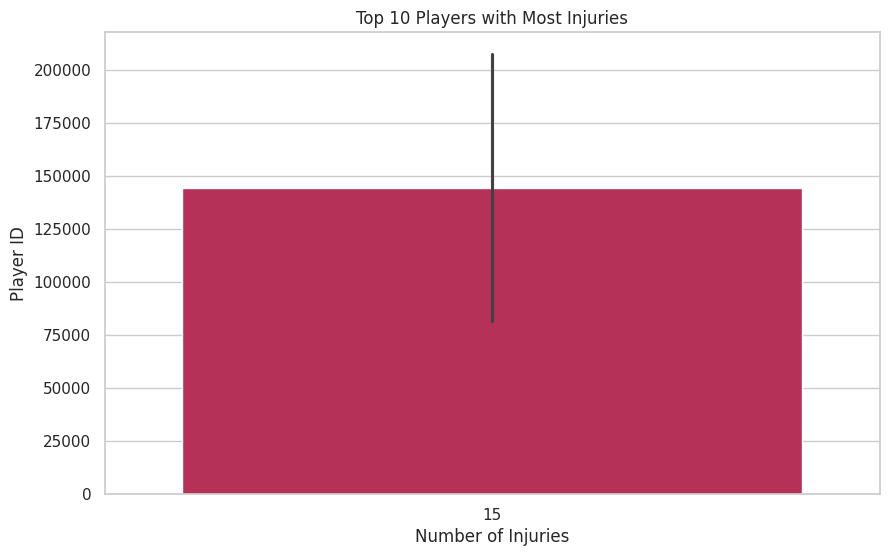

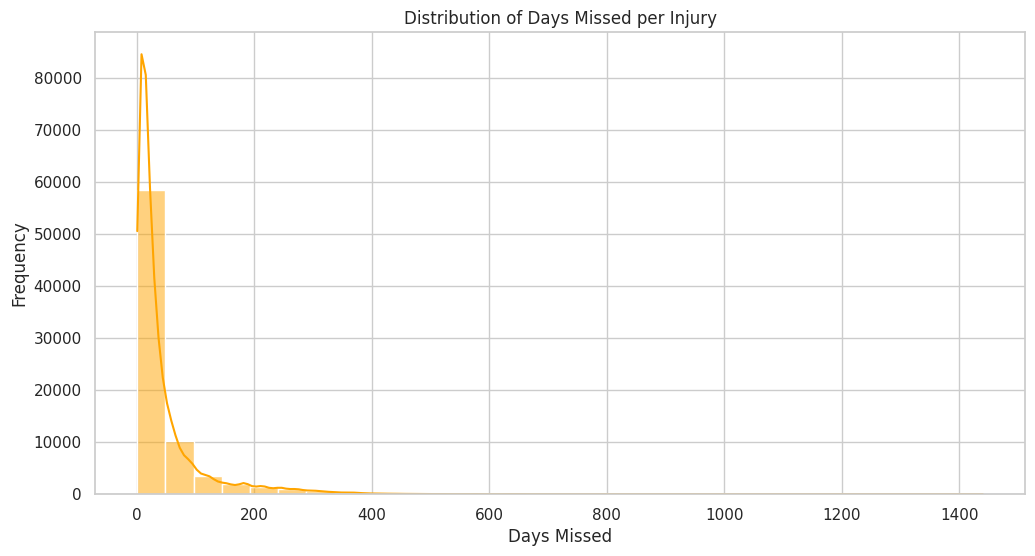

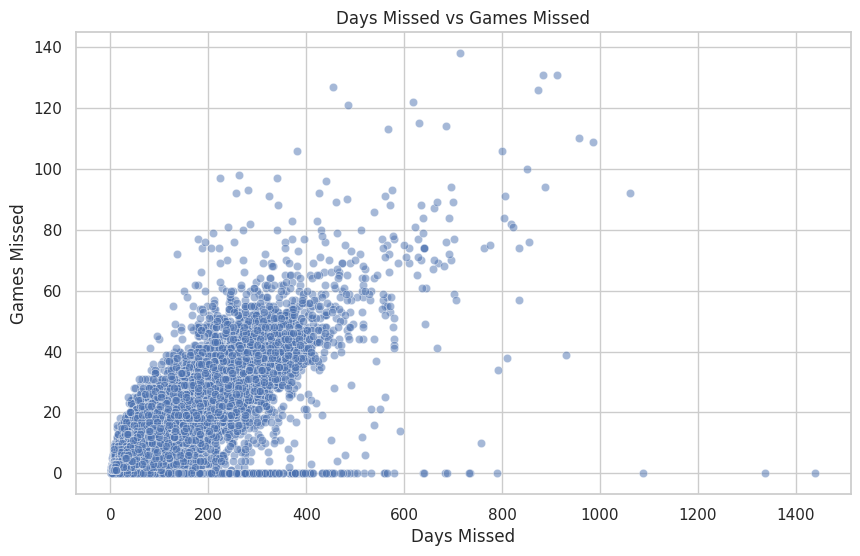

In [22]:
# Exploratory Data Analysis (EDA)

# Total injuries per season
injuries_per_season = df_injury.groupby('season_name').size().reset_index(name='injury_count')
plt.figure(figsize=(12,6))
sns.barplot(data=injuries_per_season, x='season_name', y='injury_count', palette='magma')
plt.xticks(rotation=45)
plt.title('Total Injuries per Season')
plt.ylabel('Number of Injuries')
plt.xlabel('Season')
plt.show()

# Most common injury reasons
top_injuries = df_injury['injury_reason'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_injuries.values, y=top_injuries.index, palette='viridis')
plt.title('Top 10 Most Common Injury Reasons')
plt.xlabel('Number of Injuries')
plt.ylabel('Injury Reason')
plt.show()

# Players with most injuries
top_players = df_injury.groupby('player_id').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_players.values, y=top_players.index, palette='rocket')
plt.title('Top 10 Players with Most Injuries')
plt.xlabel('Number of Injuries')
plt.ylabel('Player ID')
plt.show()

# Distribution of days missed
plt.figure(figsize=(12,6))
sns.histplot(df_injury['days_missed'], bins=30, kde=True, color='orange')
plt.title('Distribution of Days Missed per Injury')
plt.xlabel('Days Missed')
plt.ylabel('Frequency')
plt.show()

# Days missed vs games missed
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_injury, x='days_missed', y='games_missed', alpha=0.5)
plt.title('Days Missed vs Games Missed')
plt.xlabel('Days Missed')
plt.ylabel('Games Missed')
plt.show()

Days Missed - RMSE: 50.11, R²: 0.40


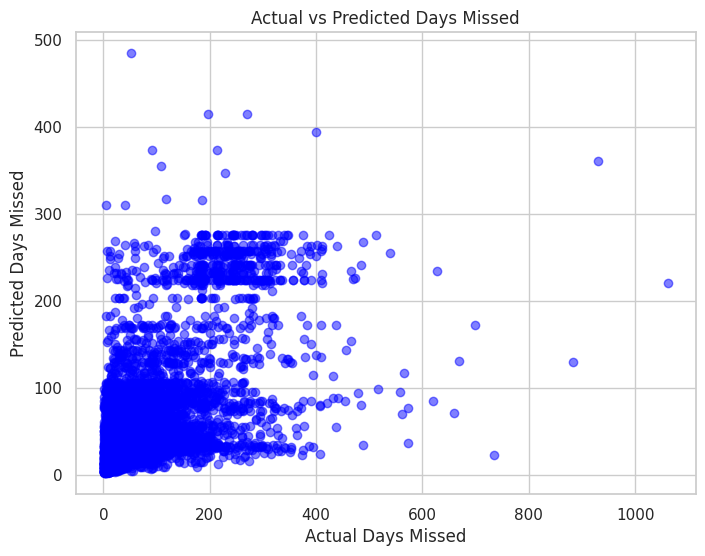

Games Missed - RMSE: 6.99, R²: 0.32


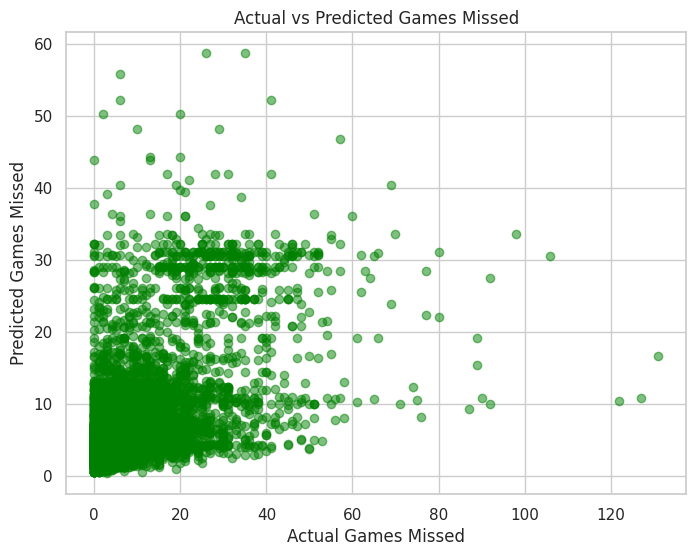

In [23]:
#Regression: Predict Days/Games Missed

# Encode categorical features
le_reason = LabelEncoder()
df_injury['injury_reason_encoded'] = le_reason.fit_transform(df_injury['injury_reason'].astype(str))

le_season = LabelEncoder()
df_injury['season_encoded'] = le_season.fit_transform(df_injury['season_name'].astype(str))

features = ['injury_reason_encoded', 'season_encoded']
X = df_injury[features]
y_days = df_injury['days_missed']
y_games = df_injury['games_missed']

# Predict Days Missed
X_train, X_test, y_train, y_test = train_test_split(X, y_days, test_size=0.2, random_state=42)
reg_days = RandomForestRegressor(n_estimators=100, random_state=42)
reg_days.fit(X_train, y_train)
y_pred_days = reg_days.predict(X_test)

rmse_days = np.sqrt(mean_squared_error(y_test, y_pred_days))
r2_days = r2_score(y_test, y_pred_days)
print(f"Days Missed - RMSE: {rmse_days:.2f}, R²: {r2_days:.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_days, alpha=0.5, color='blue')
plt.xlabel("Actual Days Missed")
plt.ylabel("Predicted Days Missed")
plt.title("Actual vs Predicted Days Missed")
plt.show()

# Predict Games Missed
X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X, y_games, test_size=0.2, random_state=42)
reg_games = RandomForestRegressor(n_estimators=100, random_state=42)
reg_games.fit(X_train_g, y_train_g)
y_pred_games = reg_games.predict(X_test_g)

rmse_games = np.sqrt(mean_squared_error(y_test_g, y_pred_games))
r2_games = r2_score(y_test_g, y_pred_games)
print(f"Games Missed - RMSE: {rmse_games:.2f}, R²: {r2_games:.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test_g, y_pred_games, alpha=0.5, color='green')
plt.xlabel("Actual Games Missed")
plt.ylabel("Predicted Games Missed")
plt.title("Actual vs Predicted Games Missed")
plt.show()


Multi-class Injury Classification Report
              precision    recall  f1-score   support

   Long-Term       0.42      0.58      0.49      2004
 Medium-Term       0.36      0.42      0.39      3877
  Short-Term       0.79      0.67      0.73      9686

    accuracy                           0.60     15567
   macro avg       0.52      0.56      0.53     15567
weighted avg       0.63      0.60      0.61     15567



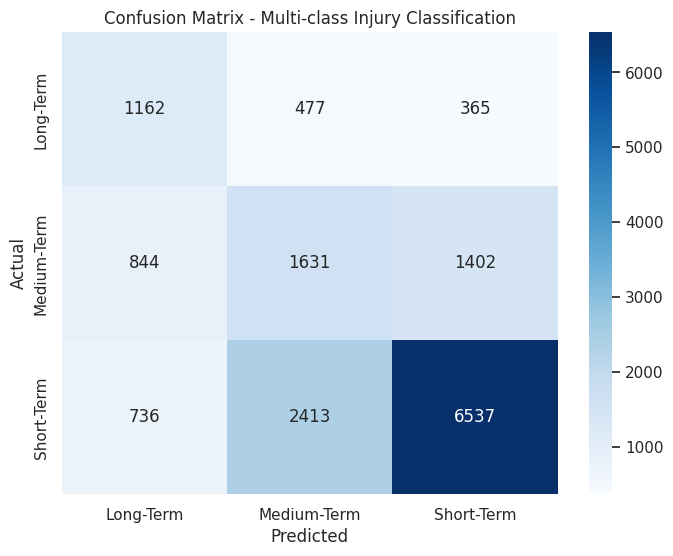

/tmp/ipython-input-4187002230.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_cls, x='Importance', y='Feature', palette="viridis")


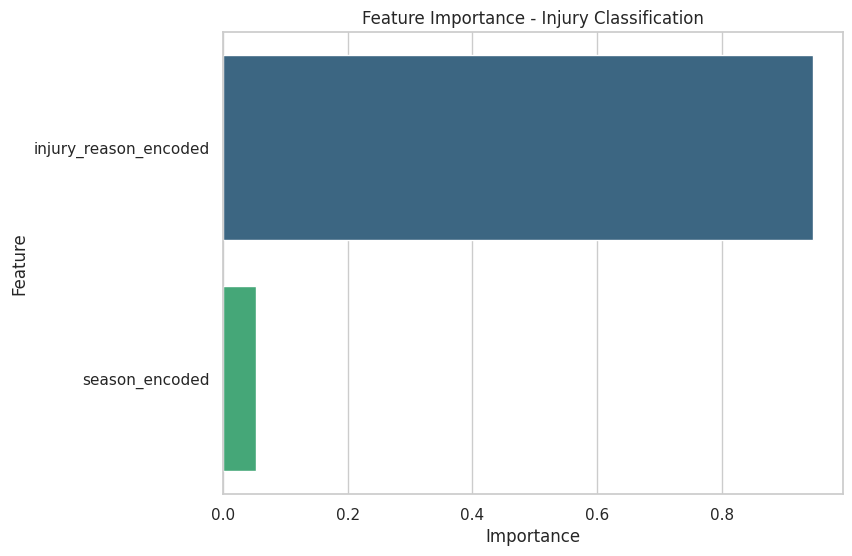

In [24]:
#Classification: Short / Medium / Long-Term Injury

# Define injury classes
df_injury['InjuryClass'] = pd.cut(
    df_injury['days_missed'],
    bins=[-1, 30, 90, df_injury['days_missed'].max()],
    labels=['Short-Term', 'Medium-Term', 'Long-Term']
)

X_cls = df_injury[features]
y_cls = df_injury['InjuryClass']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Balance classes using SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_c, y_train_c)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
clf.fit(X_res, y_res)
y_pred_c = clf.predict(X_test_c)

# Classification report
print("Multi-class Injury Classification Report")
print(classification_report(y_test_c, y_pred_c))

# Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred_c, labels=['Long-Term','Medium-Term','Short-Term'])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Long-Term','Medium-Term','Short-Term'],
            yticklabels=['Long-Term','Medium-Term','Short-Term'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multi-class Injury Classification')
plt.show()

# Feature Importance
importances_cls = clf.feature_importances_
feat_imp_cls = pd.DataFrame({'Feature': features, 'Importance': importances_cls}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp_cls, x='Importance', y='Feature', palette="viridis")
plt.title("Feature Importance - Injury Classification")
plt.show()